In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F
import math
 
import torch
import torch.nn as nn
from torch.nn.functional import softmax
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F
import math
import spacy
from torchtext.datasets import Multi30k
 
import os
import torch
import pandas as pd
from PIL import Image
import spacy
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import nltk
 
torch.manual_seed(17)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.optim import Adam, SGD
from math import floor
from torch.utils.data import Dataset
from __future__ import division
import math
from PIL import Image, ImageOps
try:
    import accimage
except ImportError:
    accimage = None
import numbers
import types
import collections
from torchvision import transforms
from scipy.ndimage import gaussian_filter
import torchvision.models as models
from matplotlib import image
import matplotlib.pyplot as plt
import random
random.seed(9)
from sklearn.model_selection import train_test_split
from nltk.translate.nist_score import corpus_nist
from nltk.translate.bleu_score import corpus_bleu



import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time


SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

!pip install -q pyonmttok
import pyonmttok

     |████████████████████████████████| 14.3MB 208kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -uq "/content/drive/MyDrive/DL_HW4/AFEC-merged-all.zip" -d "/content"
!unzip -uq "/content/drive/MyDrive/DL_HW4/Test.zip" -d "/content"

**I used these tutorials aid to write my cide:**

https://towardsdatascience.com/byte-pair-encoding-the-dark-horse-of-modern-nlp-eb36c7df4f10 https://www.youtube.com/watch?v=U0s0f995w14 https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51 https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb#scrollTo=IGGB4rUy_0zx

In [3]:
class Vocabulary:
  def __init__(self,repeated,tokenizer):
    self.num2word={0:'<PAD>',1:'<SOS>',2:'<EOS>',3:'<UNK>'}
    self.word2num={b:a for a,b in self.num2word.items()}
    self.tokenizer=tokenizer
    self.repeated=repeated
 
 
  def preprocess(self,sentence):
    tokenized_sentence=self.tokenizer.tokenize(sentence)[0]
    return tokenized_sentence 
 
  def Update_Vocabulary(self,lst_sentences):
    repeated_words={} 
    for sentence in lst_sentences:
      words=self.preprocess(sentence)
      for word in words:
        if word in repeated_words:
          repeated_words[word]=repeated_words[word]+1
        else:
          repeated_words[word]=1
        if repeated_words[word]==self.repeated:
          new_num=len(self.num2word)
          self.num2word[new_num]=word
          self.word2num[word]=new_num
  
  def sentence_to_numbers(self,sentence): 
    numbers=[]
    words=self.preprocess(sentence)
    for word in words:
      if word in self.word2num:
        number=self.word2num[word]
      else:
        number=self.word2num['<UNK>']
      numbers.append(number)
    return numbers

In [4]:
english_path='/content/AFEC-merged.en'
farsi_path='/content/AFEC-merged.fa'

args={"mode":"aggressive","case_feature":True,"joiner_annotate":True,"joiner":"_","preserve_placeholders":True,"preserve_segmented_tokens":True}
tokenizer_en=pyonmttok.Tokenizer(**args)
learner_en=pyonmttok.BPELearner(tokenizer_en,symbols=32000)
learner_en.ingest_file(english_path)
tokenizer_en=learner_en.learn("model-32k")

tokenizer_fa=pyonmttok.Tokenizer(**args)
learner_fa=pyonmttok.BPELearner(tokenizer_fa,symbols=32000)
learner_fa.ingest_file(farsi_path)
tokenizer_fa=learner_fa.learn("model-32k")

In [5]:
english_path='/content/AFEC-merged.en'
farsi_path='/content/AFEC-merged.fa'


f=open(english_path,'r')
en_lines=f.readlines()
f.close()

f=open(farsi_path,'r')
fa_lines=f.readlines()
f.close()

English_Vocabulary=Vocabulary(5,tokenizer_en)
English_Vocabulary.Update_Vocabulary(en_lines)

Farsi_Vocabulary=Vocabulary(5,tokenizer_fa)
Farsi_Vocabulary.Update_Vocabulary(fa_lines)

In [6]:
def Positional_Encoder(x):
    x_size=x.size()

    pos=torch.arange(x_size[1],dtype=torch.float,device=device) #place of each token in a sequence
 
    embd_feature_num=torch.arange(x_size[2],dtype=torch.float,device=device)
    embd_feature_num=embd_feature_num.reshape(1,1,-1)
    i_s=embd_feature_num//2
 
    angle=pos.reshape(1,-1,1)/(10000**(2*i_s/x_size[2]))
    PE=torch.where(embd_feature_num.long()%2==0,torch.sin(angle),torch.cos(angle))

    PE.required_grad=False
    return PE
 

In [7]:
class Multi_Head_Attention(nn.Module):
  def __init__(self,embed_size,num_heads,dim_key,dim_value,dim_inner):
    super(Multi_Head_Attention,self).__init__()
    self.embed_size=embed_size
    self.num_heads=num_heads
    self.dim_key=dim_key
    self.dim_value=dim_value
    self.dim_inner=dim_inner

    self.query_linear=nn.Linear(self.embed_size,self.num_heads*self.dim_key)
    self.key_linear=nn.Linear(self.embed_size,self.num_heads*self.dim_key)
    self.value_linear=nn.Linear(self.embed_size,self.num_heads*self.dim_value)

    self.dropout_layer=nn.Dropout(0.1)

    self.fc_layer=nn.Linear(self.num_heads*self.dim_value,self.embed_size)

 
  def scaled_dot_product_attention(self,q,k,v,en_mask):
    x=q.matmul(k.transpose(-2,-1))
    x=x/(self.dim_key**0.5)

    if en_mask!=None:
      x=x.masked_fill(en_mask==1,float("-inf"))
    attention=softmax(x,dim=-1)
    x=self.dropout_layer(attention)
    x=x.matmul(v)
    return x
 
    
  def forward(self,Q,K,V,en_mask=None):
 
    batch_size=Q.size(0)

    q_len=Q.size(1)
    k_len=K.size(1)
    v_len=V.size(1)

    Q=self.query_linear(Q)
    K=self.key_linear(K)
    V=self.value_linear(V)

    #splitting to heads
    Q=Q.view(batch_size,q_len,self.num_heads,self.dim_key)
    Q=Q.transpose(1,2)

    K=K.view(batch_size,k_len,self.num_heads,self.dim_key)
    K=K.transpose(1,2)

    V=V.view(batch_size,v_len,self.num_heads,self.dim_value)
    V=V.transpose(1,2)

    out=self.scaled_dot_product_attention(Q,K,V,en_mask)
    """ 

    take good care of here

    """
    out=out.permute(0, 2, 1, 3).contiguous()

    out=out.view(batch_size,-1,self.num_heads*self.dim_value)

    out=self.fc_layer(out)


    return out

  

In [8]:
class POS_FFN(nn.Module):
  def __init__(self,embed_size,dim_inner):
    super(POS_FFN,self).__init__()
    self.embed_size=embed_size
    self.dim_inner=dim_inner
 
    self.linear1=nn.Linear(self.embed_size,self.dim_inner)
    self.linear2=nn.Linear(self.dim_inner,self.embed_size)
    self.dropout_layer=nn.Dropout(0.1)
 
  def forward(self,x):
    x=self.linear1(x)
    x=torch.relu(x)
    x=self.dropout_layer(x)

    x=self.linear2(x)
 
    return x

In [9]:
class Encoder_Layer(nn.Module):
  def __init__(self,embed_size,num_heads,dim_key,dim_value,dim_inner):
    super(Encoder_Layer,self).__init__()
    self.multi_head_attention=Multi_Head_Attention(embed_size,num_heads,dim_key,dim_value,dim_inner)
    self.norm1=nn.LayerNorm(embed_size)
    self.feedforward=POS_FFN(embed_size,dim_inner)
    self.norm2=nn.LayerNorm(embed_size)
    self.dropout_layer=nn.Dropout(0.1)


  def forward(self,x,x_mask):
    x_out=self.multi_head_attention(x,x,x,x_mask)
    x_out=self.dropout_layer(x_out)
    x=self.norm1(x+x_out)
 
    x_out=self.feedforward(x)
    x_out=self.dropout_layer(x_out)
    x=self.norm2(x+x_out)

    return x


In [10]:
class Encoder(nn.Module):
  def __init__(self,embed_size,num_heads,dim_key,dim_value,dim_inner,src_vocab_size):
    super(Encoder,self).__init__()
    self.scale=embed_size**0.5
    self.embedding=nn.Embedding(src_vocab_size,embed_size)
    self.encoder_layer1=Encoder_Layer(embed_size,num_heads,dim_key,dim_value,dim_inner)
    self.encoder_layer2=Encoder_Layer(embed_size,num_heads,dim_key,dim_value,dim_inner)
    self.encoder_layer3=Encoder_Layer(embed_size,num_heads,dim_key,dim_value,dim_inner)
    self.dropout_layer=nn.Dropout(0.1)  


  def forward(self,x,x_mask):
    x=self.embedding(x)
    x=x*self.scale+Positional_Encoder(x)
    x=self.dropout_layer(x)
    x=self.encoder_layer1(x,x_mask)
    x=self.encoder_layer2(x,x_mask)
    x=self.encoder_layer3(x,x_mask)

    return x


In [11]:
class Decoder(nn.Module):
  def __init__(self,embed_size,num_heads,dim_inner,layer_num,tgt_vocab_size):
    super(Decoder,self).__init__()
    self.scale=embed_size**0.5
    self.embedding=nn.Embedding(tgt_vocab_size,embed_size)
    self.decoder_layer=nn.TransformerDecoderLayer(embed_size,num_heads,dim_feedforward=dim_inner,batch_first=True)
    self.decoder_whole=nn.TransformerDecoder(self.decoder_layer,layer_num)
    self.dropout_layer=nn.Dropout(0.1)

  def forward(self,tgt,src,mask_dic):
    tgt=self.embedding(tgt)
    tgt=tgt*self.scale+Positional_Encoder(tgt)
    tgt=self.dropout_layer(tgt)
    out=self.decoder_whole(tgt,src,**mask_dic)
    return out


In [12]:
class Transformer(nn.Module):
  def __init__(self,embed_size,num_heads,dim_key,dim_value,dim_inner,layer_num,src_vocab_size,tgt_vocab_size):
    super(Transformer,self).__init__()
    self.encoder=Encoder(embed_size,num_heads,dim_key,dim_value,dim_inner,src_vocab_size)
    self.decoder=Decoder(embed_size,num_heads,dim_inner,layer_num,tgt_vocab_size)
    self.fc=nn.Linear(embed_size,tgt_vocab_size)

    
    #masks creditted to 
    #https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb#scrollTo=IGGB4rUy_0zx

  def build_source_mask(self,source):
    source_mask=source ==0
    return source_mask.unsqueeze(1).unsqueeze(2).to(device)

  def build_pad_mask(self,seq):
    the_mask=seq==0
    return the_mask.to(device)

  def build_target_mask(self,target):
    sz=target.size(1)
    trg_mask=(torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    trg_mask=trg_mask.float().masked_fill(trg_mask==0,float('-inf')).masked_fill(trg_mask==1,float(0.0))
    return trg_mask.to(device)

  def forward(self,source,target):

    source_mask=self.build_source_mask(source)
    

    memory_p_mask=self.build_pad_mask(source)
    target_mask=self.build_target_mask(target)
    target_p_mask=self.build_pad_mask(target)

    source=self.encoder(source,source_mask)
    
    mask_dic={'tgt_mask':target_mask,'memory_mask':None,'tgt_key_padding_mask':target_p_mask, 'memory_key_padding_mask':memory_p_mask}

    out=self.decoder(target,source,mask_dic)

    out=self.fc(out)

    return out

In [13]:
class Customized_Dataset(Dataset):
  def __init__(self,en_list,fa_list,en_vocab,fa_vocab):
 
    self.en_list=en_list
    self.fa_list=fa_list
 
    self.en_vocab=en_vocab
    self.fa_vocab=fa_vocab
 
 
  def __len__(self):
    L=len(self.en_list)
    return L
 
  def __getitem__(self,index):
    
    en_sen=self.en_list[index]
    en2num=[1]+self.en_vocab.sentence_to_numbers(en_sen)+[2]
    en2num=torch.tensor(en2num)
 
    fa_sen=self.fa_list[index]
    fa2num=[1]+self.fa_vocab.sentence_to_numbers(fa_sen)+[2]
    fa2num=torch.tensor(fa2num)
 
    return en2num,fa2num

In [14]:
 class PaddingBatches:
  def __call__(self,mini_batch):
    source_lst=[]
    target_lst=[]
    for s,t in mini_batch:
      source_lst.append(s)
      target_lst.append(t)
 
    source_lst=pad_sequence(source_lst,padding_value=0,batch_first=True)
   
    target_lst=pad_sequence(target_lst,padding_value=0,batch_first=True)
    
 
    return source_lst,target_lst

In [15]:
Batch_Size=32
embed_size=256
num_heads=8
dim_key=64
dim_value=64
dim_inner=1024
layer_num=3
src_vocab_size=len(English_Vocabulary.word2num)
tgt_vocab_size=len(Farsi_Vocabulary.word2num)

learning_rate=0.0001
Betas_range=(0.9,0.98)
eps_value=1e-9

x_train,x_val,y_train,y_val=train_test_split(en_lines,fa_lines, test_size=0.1, random_state=42)
 

params={'batch_size': Batch_Size,
          'shuffle': True,
          'num_workers': 6,'collate_fn':PaddingBatches()}
 
dataset=Customized_Dataset(x_train,y_train,English_Vocabulary,Farsi_Vocabulary)
train_generator=DataLoader(dataset,**params)


params_val={'batch_size': 10,
          'shuffle': True,
          'num_workers': 6,'collate_fn':PaddingBatches()}

dataset_val=Customized_Dataset(x_val,y_val,English_Vocabulary,Farsi_Vocabulary)
val_generator=DataLoader(dataset_val,**params_val)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
model=Transformer(embed_size,num_heads,dim_key,dim_value,dim_inner,layer_num,src_vocab_size,tgt_vocab_size).to(device)
criterian=nn.CrossEntropyLoss(ignore_index=0) 
optimizer=Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learning_rate,betas=Betas_range,eps=eps_value)
 
epochs=20
 
train_loss_lst=[] #pe: per 10 iteration
 
val_loss_lst=[] #pe: per epoch

it_sz=150

nn=750

for epoch in range(epochs):
  running_loss=0
  n=0
  tr_l_pe=0
  for i,(XX,YY) in enumerate(train_generator):
    n=n+1
    XX=XX.to(device)
    YY=YY.to(device)

    optimizer.zero_grad()

    outputs=model(XX,YY[:,:-1])

    output_dim=outputs.shape[-1]

    outputs = outputs.contiguous().view(-1, output_dim)
    YY = YY[:,1:].contiguous().view(-1)
 
    loss=criterian(outputs,YY)
 
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
 
    optimizer.step()
 
    running_loss+=loss.item()

    
    if i%it_sz==(it_sz-1):
      print('[%d,%5d] train loss: %f'%(epoch+1,i+1,running_loss/it_sz))
      train_loss_lst.append(running_loss/it_sz)
      running_loss=0

      running_loss_val=0
      n1=0
      for j,(XX_val,YY_val) in enumerate(val_generator):
        n1=n1+1
        XX_val=XX_val.to(device)
        YY_val=YY_val.to(device)

        outputs_val=model(XX_val,YY_val[:,:-1])

        output_dim_val=outputs_val.shape[-1]

        outputs_val = outputs_val.contiguous().view(-1, output_dim_val)
        YY_val = YY_val[:,1:].contiguous().view(-1)
    
        loss_val=criterian(outputs_val,YY_val)

        running_loss_val+=loss_val.item()
        if n1==10:
          break
      print('[%d,%5d] val loss: %f'%(epoch+1,i+1,running_loss_val/n1))
      val_loss_lst.append(running_loss_val/n1)
      if len(val_loss_lst)==nn:
        break
    if len(val_loss_lst)==nn:
        break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)

[1,  150] train loss: 8.120244
[1,  150] val loss: 7.006501
[1,  300] train loss: 6.753753
[1,  300] val loss: 6.562801
[1,  450] train loss: 6.558768
[1,  450] val loss: 6.491592
[1,  600] train loss: 6.415642
[1,  600] val loss: 6.287014
[1,  750] train loss: 6.292838
[1,  750] val loss: 6.396667
[1,  900] train loss: 6.205105
[1,  900] val loss: 6.126094
[1, 1050] train loss: 6.127204
[1, 1050] val loss: 6.088767
[1, 1200] train loss: 6.045751
[1, 1200] val loss: 6.030107
[1, 1350] train loss: 6.006832
[1, 1350] val loss: 5.934592
[1, 1500] train loss: 5.971934
[1, 1500] val loss: 6.063160
[1, 1650] train loss: 5.894015
[1, 1650] val loss: 5.767847
[1, 1800] train loss: 5.854511
[1, 1800] val loss: 5.997239
[1, 1950] train loss: 5.821502
[1, 1950] val loss: 5.635509
[1, 2100] train loss: 5.755910
[1, 2100] val loss: 5.829309
[1, 2250] train loss: 5.754061
[1, 2250] val loss: 5.708641
[1, 2400] train loss: 5.731368
[1, 2400] val loss: 5.781079
[1, 2550] train loss: 5.691239
[1, 2550]

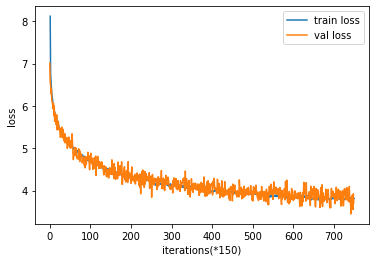

In [17]:
#plotting loss
plt.figure()
itr_lst=list(range(1,len(val_loss_lst)+1))
plt.plot(itr_lst,train_loss_lst)
plt.plot(val_loss_lst)
plt.xlabel('iterations(*150)')
plt.ylabel('loss')
plt.legend(['train loss','val loss'])


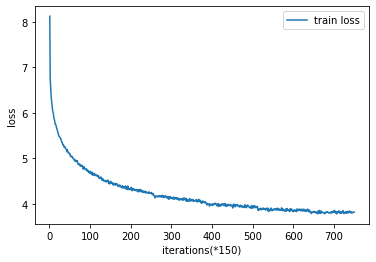

In [18]:
#plotting loss
plt.figure()
itr_lst=list(range(1,len(val_loss_lst)+1))
plt.plot(itr_lst,train_loss_lst)
plt.xlabel('iterations(*150)')
plt.ylabel('loss')
plt.legend(['train loss'])


In [46]:
def lines_and_tokenized(path,tokenizer):
  f=open(path,'r')
  lines=f.readlines()

  list_1=[]
  list_2=[]
  for line in lines:
    line=tokenizer.tokenize(line)[0]
    list_1.append(line)
    line=" ".join(line)
    line=line.replace("_ ","")
    line=line.replace(" _","")
    line=line.replace("_","")
    list_2.append(line)

  return list_2,list_1


original_en_path='/content/Test/test.en'
org_lines,org_lines_tokenized=lines_and_tokenized(original_en_path,tokenizer_en)

ref0_path='/content/Test/test.fa0'
ref0_lines,ref0_lines_tokenized=lines_and_tokenized(ref0_path,tokenizer_fa)

ref1_path='/content/Test/test.fa1'
ref1_lines,ref1_lines_tokenized=lines_and_tokenized(ref1_path,tokenizer_fa)

ref2_path='/content/Test/test.fa2'
ref2_lines,ref2_lines_tokenized=lines_and_tokenized(ref2_path,tokenizer_fa)

ref3_path='/content/Test/test.fa3'
ref3_lines,ref3_lines_tokenized=lines_and_tokenized(ref3_path,tokenizer_fa)

refs=[]
for kk in range(len(org_lines)):
  refs.append([ref0_lines_tokenized[kk],ref1_lines_tokenized[kk],ref2_lines_tokenized[kk],ref3_lines_tokenized[kk]])


greedy search credited to 
https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb#scrollTo=IGGB4rUy_0zx

In [47]:
def greedy_search(test_data,model,max_len):
  test_data=test_data.to(device)

  mask_encoder=model.build_source_mask(test_data)
  encoded=model.encoder(test_data,mask_encoder)
  
  memory_p_mask=model.build_pad_mask(test_data)

  target_indices=[1]
  for i in range(max_len):
    test_y=torch.LongTensor(target_indices).unsqueeze(0).to(device)

    target_mask=model.build_target_mask(test_y)
    
    decoder_dic={'tgt_mask':target_mask,'memory_mask':None,'tgt_key_padding_mask':None, 'memory_key_padding_mask':memory_p_mask}
    decoded=model.decoder(test_y,encoded,decoder_dic)
    out=model.fc(decoded)

    predicted=out.argmax(2)[:,-1].item()

    target_indices.append(predicted)

    if predicted==2:
      break
  return target_indices

def translate(the_tokens_list,the_vocabulary):
  translated = [the_vocabulary.num2word[i] for i in the_tokens_list]
  return translated[1:-1]


def to_num(a_sen,a_vocabulary):
  a_sen_2num=[1]+a_vocabulary.sentence_to_numbers(a_sen)+[2]
  a_sen_2num=torch.tensor(a_sen_2num).unsqueeze(0)
  return a_sen_2num

def translated_lines(model,source_lines,source_vocabulary,target_vocabulary,max_len): 
  fa_translated=[]
  for line in source_lines:
    line=to_num(line,source_vocabulary)
    line=greedy_search(line,model,max_len)
    line=translate(line,target_vocabulary)
    fa_translated.append(line)
  return fa_translated

def whole_sen(tokenized_sen_list):
  a_list=[]
  for line in tokenized_sen_list:
    line=" ".join(line)
    line=line.replace("_ ","")
    line=line.replace(" _","")
    line=line.replace("_","")
    a_list.append(line)
  return a_list

f=open(original_en_path,'r')
org_lines_test=f.readlines()
f.close()

fa_translated_tokenized=translated_lines(model,org_lines_test,English_Vocabulary,Farsi_Vocabulary,150)
fa_translated_lines=whole_sen(fa_translated_tokenized)

In [48]:
def print_lines(list1,list2,list3,k):
  print(list1[k])
  print(list2[k])
  print(list3[k])
  print('\n')


In [49]:
print_lines(org_lines,ref1_lines,fa_translated_lines,2)

print_lines(org_lines,ref0_lines,fa_translated_lines,8)

print_lines(org_lines,ref0_lines,fa_translated_lines,15)

do you go by car and i go by train ?
آیا شما با اتومبیل میروید و من با قطار میروم ؟
آیا شما با ماشین قطار می‌روم و با ماشین می‌روم ?


what did you say , please ?
شما چه گفتید ، لطفا ؟
لطفا , چه چیزی انجام می‌دهید ?


yes . when and where do we want to meet ?
بله . پس کی و کجا باید یکدیگر را ملاقات کنیم ؟
و چه زمانی ما میتوانیم همدیگر را ملاقات کنیم ?




In [50]:
print_lines(org_lines,ref1_lines,fa_translated_lines,16)

print_lines(org_lines,ref0_lines,fa_translated_lines,18)

print_lines(org_lines,ref2_lines,fa_translated_lines,23)

i prefer the plane .
من هواپیما را ترجیح میدهم .
من ترجیح می‌دهم هواپیما را ترجیح میدهم .


no idea . we will see . it does not matter .
نظری ندارم . یکدیگر را میبینیم . مهم نیست .
ما هیچ ایده ای نمی‌بینیم .


what is planned for the evening ?
برای عصر چه برنامه­ای گذاشته شده است ؟
عصر برای عصر برنامه-ریزی شده است ?




In [51]:
print_lines(org_lines,ref1_lines,fa_translated_lines,25)

print_lines(org_lines,ref1_lines,fa_translated_lines,26)

print_lines(org_lines,ref1_lines,fa_translated_lines,28)


fine . i think we have arranged everything . then we will meet tomorrow .
خوبه . من فکر میکنم ما ترتیب همه چیز را دادیم . پس ما فردا ملاقات خواهیم کرد .
پس من فکر میکنم که همه چیز را ملاقات کنیم . پس ما باید خوب را ملاقات کنیم .


hello . we have to talk about our trip to hanover .
سلام . ما باید درمورد سفرمان به هانوفر صحبت کنیم .
سلام به سفر ما باید درباره سفر کنیم .


i have already booked a flight .
من یک پرواز را رزرو کرده­ام .
من یک پرواز رزرو کردم .




In [52]:
print_lines(org_lines,ref1_lines,fa_translated_lines,30)

print_lines(org_lines,ref1_lines,fa_translated_lines,36)

print_lines(org_lines,ref1_lines,fa_translated_lines,39)

we will have to meet at the airport at seven o'clock .
ما باید ساعت هفت در فرودگاه ملاقات کنیم .
ما باید هفت ساعت هفت ملاقات کنیم .


the best thing is we meet at the train station at eight o'clock .
بهترین چیز این است که ما شاعت هشت در ایستگاه قطار ملاقات کنیم .
ساعت هشت چیز در بهترین زمینه آموزش‌های قطار است .


goodbye .
خداحافظ .
خداحافظ .




In [53]:
print_lines(org_lines,ref1_lines,fa_translated_lines,101)

print_lines(org_lines,ref1_lines,fa_translated_lines,150)

print_lines(org_lines,ref1_lines,fa_translated_lines,180)

okay . should we go to the hotel by taxi immediately ?
باشه . ما باید فورا با تاکسی به هتل برویم ؟
بسیار خوب باید با راننده تاکسی به هتل برویم .


okay . should we meet at the hotel at half past seven ?
باشه . ما باید هفت و نیم در هتل ملاقات کنیم ؟
خوب ما باید ساعت هفت در هتل ملاقات کنیم ?


good morning . how are you ?
صبح به­خیر . حال شما چطور است ؟
خوب , صبح خوب است ?




In [54]:
print_lines(org_lines,ref0_lines,fa_translated_lines,65)

print_lines(org_lines,ref3_lines,fa_translated_lines,131)

print_lines(org_lines,ref3_lines,fa_translated_lines,110)

i did not understand that .
من آن را نفهمیدم .
آن را درک نمی‌کنم .


unfortunately i did not understand you .
متاسفانه منظورت را نفهمیدم .
متأسفانه من شما را درک نمی‌کنم .


i prefer the plane .
من هواپیما را ترجیح میدهم .
من هواپیما را ترجیح دادم .




In [55]:
bleu_score=corpus_bleu(refs,fa_translated_tokenized)
print('BLEU is '+str(bleu_score))
nist_score=corpus_nist(refs,fa_translated_tokenized)
print('NIST is '+str(nist_score))

BLEU is 0.1075225802187754
NIST is 0.0009707774813979547


In [31]:
torch.save(model,'/content/model')
torch.save(model,'/content/drive/MyDrive/DL_HW4/Q2_2/model_whole')
torch.save(model.state_dict(), '/content/drive/MyDrive/DL_HW4/Q2_2/model')